<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/BSEP_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BSEP Inhibition Model Creation and Prediction
The data source is https://github.com/ATOMconsortium/AMPL/tree/master/atomsci/ddm/examples/BSEP.  

The notebook is based on the modeling procedure published in the following manscript, https://arxiv.org/abs/2002.12541, and provides AMPL code to create/test Random Forest (RF) model. The notebook ends by testing the RF model using an external test data. Please note the datasets used in this notebook came from AMPL github site.  

# Basic biology of BSEP gene
You can read about BSEP gene here, 

https://en.wikipedia.org/wiki/ABCB11

and/or here,

http://useast.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000276582;r=CHR_HSCHR2_1_CTG7_2:168939927-168953422 

BSEP or ABCB11 is a gene associated with the disease progressive familial intrahepatic cholestasis type 2 (PFIC2).PFIC2 is shown to be caused by mutations in the ABCB11 gene which increases the risk of hepatocellular carcinoma in early life.




The notebook will run through the following steps: 

1.   Clone the AMPL git repository and install the software  
2.   Use a data file from AMPL repository as input
3.   Split the data 
4.   Train a model
5.   Show how you can make predictions on the model.   
6.   If you want to use your input data, please make sure your input data should be in CSV format that contains the following information: 
        *   Row of column headers
        *   contain a column of SMILES strings for the compounds you want to run predictions on.
        * Optional information: 
                *   A column of unique compound IDs; if none is provided, one will be generated for you
                *   A column of binary activity values, if you have measured IC50s for the input compounds: 0 if the IC50 < 100 uM, 1 if IC50 >= 100 uM.

## Here is a sample input dataset with four componds

|base_rdkit_smiles | compound_name| pIC50 |relation|active |
|------------------|------------|-------|--------|-------|
|CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C3C(=O)c4c(O)cccc4[C@@](C)(O)C3CC12"	|CHEMBL198	|3.000000	|<	|0 |
|C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]43C)C1C[C@@H](O)[C@]2(O)C(=O)CO|CHEMBL3039453	|3.627825	|NaN	|1 |
|Nc1nc2cc(Cl)ccc2o1	|CHEMBL472566	|3.000000	|< |0|
|COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]5CO[C@@H](C)O[C@H]5[C@H](O)[C@H]3O)[C@H]3COC(=O)[C@H]23)OCO4)cc(OC)c1O	|CHEMBL44657	|3.876148	|<|	0 |



## Before you begin, make sure you close all other COLAB notebooks. 

# Change Runtime settings

## Plesae change your runtime settings to use GPU and high-memory, if you have 

## Runtime --> Change Runtime Type --> GPU

In [ ]:
!date # starting time

Wed Apr 14 18:28:07 UTC 2021


# AMPL Installation

In [ ]:
#@title
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#@title
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

# ! wget -c https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh 
# ! chmod +x Miniconda3-py37_4.9.2-Linux-x86_64.sh
# ! time bash Miniconda3-py37_4.9.2-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-04-14 18:28:08--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  env

In [ ]:
#@title
!pip install mordred
!pip install --upgrade bravado
!pip install molvs

Requirement already up-to-date: bravado in /usr/local/lib/python3.7/site-packages (11.0.3)


In [ ]:
#@title
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

--2021-04-14 18:30:25--  https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100 (1.1K) [text/plain]
Saving to: ‘install_AMPL_GPU_test.sh.1’

install_AMPL_GPU_te 100%[===================>]   1.07K  --.-KB/s    in 0s      

2021-04-14 18:30:26 (55.6 MB/s) - ‘install_AMPL_GPU_test.sh.1’ saved [1100/1100]

mkdir: cannot create directory ‘github’: File exists
fatal: destination path 'AMPL' already exists and is not an empty directory.
M	atomsci/ddm/__init__.py
M	atomsci/ddm/pipeline/transformations.py
Already on 'pkg_upgrade'
Your branch is up to date with 'origin/pkg_upgrade'.
patching file /content/github/AMPL/atomsci/ddm/pipeline/transformations.py
Reversed (or previo

In [ ]:
# from MODAC

In [ ]:
# Obtain the files from GitHub
! wget https://raw.githubusercontent.com/ATOMconsortium/AMPL/master/atomsci/ddm/examples/BSEP/data/small_test_data.csv
! wget https://raw.githubusercontent.com/ATOMconsortium/AMPL/master/atomsci/ddm/examples/BSEP/data/morgan_warner_combined_bsep_data.csv

--2021-04-14 18:30:27--  https://raw.githubusercontent.com/ATOMconsortium/AMPL/master/atomsci/ddm/examples/BSEP/data/small_test_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1755 (1.7K) [text/plain]
Saving to: ‘small_test_data.csv.1’

small_test_data.csv 100%[===================>]   1.71K  --.-KB/s    in 0s      

2021-04-14 18:30:28 (34.3 MB/s) - ‘small_test_data.csv.1’ saved [1755/1755]

--2021-04-14 18:30:28--  https://raw.githubusercontent.com/ATOMconsortium/AMPL/master/atomsci/ddm/examples/BSEP/data/morgan_warner_combined_bsep_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

# Load the libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Load the Data

In [ ]:
df = pd.read_csv("morgan_warner_combined_bsep_data.csv")

In [ ]:
df.head(3)

,compound_name,source,base_rdkit_smiles,relation,pIC50,active
0,fenoximone,Morgan,CSc1ccc(C(=O)c2[nH]c(=O)[nH]c2C)cc1,<,3.876148,0
1,OXEDRINE,Warner,CNCC(O)c1ccc(O)cc1,<,3.000000,0
2,ccl4,Morgan,ClC(Cl)(Cl)Cl,<,3.876148,0


## Display some molecules

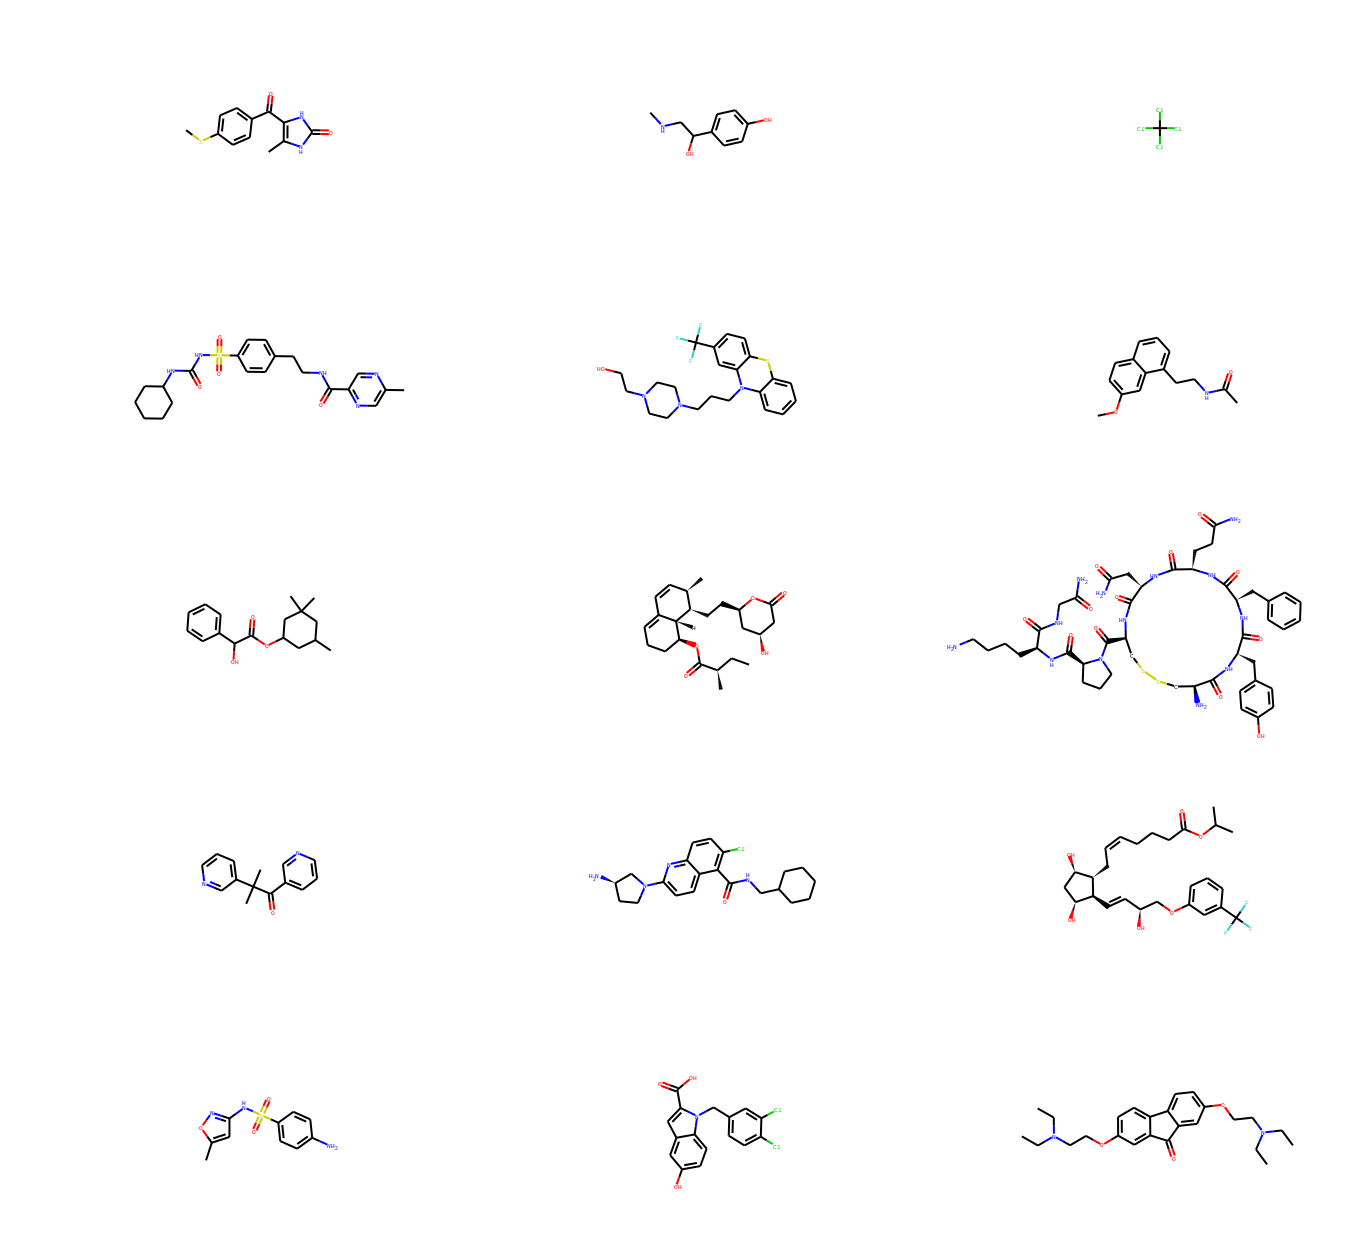

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
from itertools import islice

#Needed to show molecules
from rdkit.Chem.Draw import IPythonConsole 

from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions 
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole


molecules = [Chem.MolFromSmiles(smiles)
             for smiles in islice(df['base_rdkit_smiles'],15)]

Draw.MolsToGridImage(molecules,  subImgSize=(450,250))

# Modeling: Training

In [ ]:
response_col = "active"
compound_id = "compound_name"
smiles_col = "base_rdkit_smiles"

params = {
        "verbose": "True",
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": "/content/morgan_warner_combined_bsep_data.csv",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "False",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "/content"
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

2021-04-14 18:30:34,985 Splitting data by scaffold


number of features: 1024


2021-04-14 18:30:35,502 Dataset split table saved to /content/morgan_warner_combined_bsep_data_train_valid_test_scaffold_eb13c6fd-9afe-4111-b6b4-0c06d1ec3f45.csv
2021-04-14 18:30:37,655 Wrote model metadata to file /content/morgan_warner_combined_bsep_data/RF_ecfp_scaffold_classification/676c52e6-584c-42c3-8a07-4a931a0080e3/model_metadata.json
2021-04-14 18:30:37,719 Wrote model metrics to file /content/morgan_warner_combined_bsep_data/RF_ecfp_scaffold_classification/676c52e6-584c-42c3-8a07-4a931a0080e3/model_metrics.json


Wrote model tarball to /content/morgan_warner_combined_bsep_data_model_676c52e6-584c-42c3-8a07-4a931a0080e3.tar.gz


# Explore the model tar file 

In [ ]:
!tar -tf *.tar.gz

tar: morgan_warner_combined_bsep_data_model_7a251f6c-5644-4b8a-9eef-da8052370d89.tar.gz: Not found in archive
tar: Exiting with failure status due to previous errors


In [ ]:
!tar xzf *.tar.gz -C /tmp

tar: morgan_warner_combined_bsep_data_model_7a251f6c-5644-4b8a-9eef-da8052370d89.tar.gz: Not found in archive
tar: Exiting with failure status due to previous errors


In [ ]:
# !cat /tmp/model_metadata.json

In [ ]:
import json
import pandas as pd
data = json.load(open('/tmp/model_metadata.json'))
# pd.DataFrame(data["model_parameters"])
data['model_parameters']

{'featurizer': 'ecfp',
 'hyperparam_uuid': None,
 'model_bucket': 'public',
 'model_choice_score_type': 'roc_auc',
 'model_type': 'RF',
 'num_model_tasks': 1,
 'prediction_type': 'classification',
 'save_results': False,
 'system': 'LC',
 'time_generated': 1618420527.777955,
 'transformer_bucket': 'public',
 'transformer_key': None,
 'transformer_oid': None,
 'transformers': True,
 'uncertainty': True}

# Make a prediction on the validation test

In [ ]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
pred_results
print(f"AUC score of validation set: {pred_results['prc_auc_score']:.3f}")

AUC score of validation set: 0.726


In [ ]:
pred_data = pl.model_wrapper.get_perf_data(subset="test", epoch_label="best")
pred_results = pred_data.get_prediction_results()
# print(f"R2 score of validation set: {pred_results['r2_score']:.3f}")

In [ ]:
pred_results

{'accuracy_score': 0.6666666666666666,
 'confusion_matrix': [[[27, 7], [15, 17]]],
 'cross_entropy': 0.5954608475201348,
 'kappa': 0.3277777777777777,
 'matthews_cc': 0.33803257077915294,
 'npv': 0.6428571428571429,
 'num_compounds': 66,
 'prc_auc_score': 0.7291128239749269,
 'precision': 0.7083333333333334,
 'recall_score': 0.53125,
 'roc_auc_score': 0.7463235294117647}

# External data set
If you want to use your input data, please make sure your input data should be in CSV format that contains the following information:
Row of column headers
contain a column of SMILES strings for the compounds you want to run predictions on.
Optional information:
  *   A column of unique compound IDs; if none is provided, one will be generated for you
  *   A column of binary activity values, if you have measured IC50s for the input compounds: 0 if the IC50 < 100 uM, 1 if IC50 >= 100 uM.

Let us read a sample test data and make predictions.


In [ ]:
test_data = pd.read_csv("small_test_data.csv")
test_data.head(4)

,base_rdkit_smiles,compound_id,pIC50,relation,active
0,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,CHEMBL198,3.000000,<,0
1,C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]...,CHEMBL3039453,3.627825,NaN,1
2,Nc1nc2cc(Cl)ccc2o1,CHEMBL472566,3.000000,<,0
3,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,CHEMBL44657,3.876148,<,0


In [ ]:
# ?pl.predict_on_smiles
list_cpds = list(test_data.base_rdkit_smiles.values)

In [ ]:
test_data.rename(columns={"compound_id": "compound_name"}, inplace=True)
test_data.head(5)

,base_rdkit_smiles,compound_name,pIC50,relation,active
0,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,CHEMBL198,3.000000,<,0
1,C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]...,CHEMBL3039453,3.627825,NaN,1
2,Nc1nc2cc(Cl)ccc2o1,CHEMBL472566,3.000000,<,0
3,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,CHEMBL44657,3.876148,<,0
4,CC(=O)[C@H]1[C@H](C#N)C[C@H]2[C@@H]3CC=C4CC(O)...,CHEMBL4063685,3.876148,<,0


# Inference on the external dataset

In [ ]:
results_df = pl.predict_on_dataframe(test_data, contains_responses=True)
results_df

2021-04-14 18:30:38,074 Featurizing data...
2021-04-14 18:30:38,149 Done


number of features: 1024


,base_rdkit_smiles,actual,pred
compound_name,,,
CHEMBL198,CN(C)[C@@H]1C(O)=C(C(N)=O)C(=O)[C@@]2(O)C(O)=C...,0.0,0
CHEMBL3039453,C[C@]12C[C@H](O)[C@@]3(F)C(CCC4=CC(=O)C=C[C@@]...,1.0,0
CHEMBL472566,Nc1nc2cc(Cl)ccc2o1,0.0,0
CHEMBL44657,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,0.0,1
CHEMBL4063685,CC(=O)[C@H]1[C@H](C#N)C[C@H]2[C@@H]3CC=C4CC(O)...,0.0,1
CHEMBL1200777,N[C@H](Cc1cc(I)c(Oc2cc(I)c(O)c(I)c2)c(I)c1)C(=...,1.0,1
CHEMBL452231,COc1cc([C@@H]2c3cc4c(cc3[C@@H](O[C@@H]3O[C@@H]...,0.0,1
CHEMBL640,CCN(CC)CCNC(=O)c1ccc(N)cc1,0.0,0
CHEMBL95804,CCN(CC)CCNC(=O)c1ccc(NS(C)(=O)=O)cc1,0.0,0


## Report some performance metrics

In [ ]:
from sklearn.metrics import balanced_accuracy_score
y_true = results_df['actual'].values
y_pred = results_df['pred'].values
balanced_accuracy_score(y_true, y_pred)

0.4571428571428572

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[10,  4],
       [ 4,  1]])

In [ ]:
!date